# MADE 2019. Семинар по линейным моделям

## План

### Часть 1. Обучение и отладка моделей
#### Пример 1. Текстовая классификация
#### Пример 2. Калибровка вероятностей
#### Пример 3. Анализ поведения модели

### Часть 2. Vowpal Wabbit

## Пример 1. Текстовая классификация

In [9]:
random_state = 42

**Важное замечание:**
В учебных целях мы делаем import'ы непосредственно перед тем, как вперывые применить импортируемую функцию/класс, но не надо так делать в рабочих блокнотах. Другому человеку, запускающему блокнот на другой машине, будет **безумно** приятно вылавливать все ваши импорты, чтобы проверить наличие у него всех библиотек (и если ячейки блокнота выполняются долго, то просто повторять "run all" до успеха и доставлять то, на чем упало, - не очень удобный способ).

In [73]:
import pandas as pd

In [82]:
data = pd.read_csv("train_data.csv", index_col=0, header=0)
data.head()

,title,text,score
0,Просьба об отмене штрафа КАСКО,Здравствуйте! 10.06.2016г. мною был заключен д...,Позитивный
1,"В целом хорошо, работали по ипотеке.","Брала ипотеку в юникоре, порадовали квалифика...",Негативный
2,Нас всегда выручает банк Уралсиб!,Знакомство с банком началось с ипотеки в 2009 ...,Позитивный
3,Абсолютно неприемлемая ситуация и ее решение,Клиент Совкомбанка с 2017 года. В феврале 2018...,Позитивный
4,Внёс не туда,Пришёл оплачивать кредит и ошибочно внёс деньг...,Позитивный


In [88]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [89]:
data['score'].head()

0    Позитивный
1    Негативный
2    Позитивный
3    Позитивный
4    Позитивный
Name: score, dtype: object

In [90]:
le.fit(data['score'])

LabelEncoder()

In [116]:
y = le.transform(data['score'])

In [117]:
y

array([1, 0, 1, ..., 1, 1, 1])

In [118]:
texts = data['text']

In [124]:
?train_test_split

In [119]:
from sklearn.model_selection import train_test_split
train_texts, test_texts, y_train, y_test = \
    train_test_split(texts, y, test_size=0.33, random_state=random_state)

In [120]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('vec', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression(penalty='l1')),
])

pipeline.fit(train_texts, y_train)
test_predictions = pipeline.predict(test_texts)

/Users/xead/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [97]:
from sklearn.metrics import accuracy_score, log_loss

In [ ]:
?accuracy_score

In [98]:
print(accuracy_score(y_test, test_predictions))

0.85


In [102]:
print(log_loss(y_test, test_predictions))

5.180895692072867


In [105]:
mean_baseline = [y_train.mean()] * len(y_test)
print(log_loss(y_test, mean_baseline))

0.5787176302356803


#### Вопрос: почему так плохо?

#### Ответ: надо же для вероятностей оценивать

In [99]:
test_probs = pipeline.predict_proba(test_texts)

In [100]:
print(log_loss(y_test, test_probs))

0.3444024483442872


Для сравнения - ошибка на идеальном ответе со смещением:

In [127]:
print(log_loss(y_test, y_test + 0.1))

0.027035508317798967


## Пример 2: калибровка вероятностей

#### Пример из документации sklearn
https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration_curve.html 

In [107]:
%matplotlib inline

Logistic:
	Brier: 0.099
	Precision: 0.872
	Recall: 0.851
	F1: 0.862

Naive Bayes:
	Brier: 0.118
	Precision: 0.857
	Recall: 0.876
	F1: 0.867

Naive Bayes + Isotonic:
	Brier: 0.098
	Precision: 0.883
	Recall: 0.836
	F1: 0.859

Naive Bayes + Sigmoid:
	Brier: 0.109
	Precision: 0.861
	Recall: 0.871
	F1: 0.866

Logistic:
	Brier: 0.099
	Precision: 0.872
	Recall: 0.851
	F1: 0.862

SVC:
	Brier: 0.163
	Precision: 0.872
	Recall: 0.852
	F1: 0.862

SVC + Isotonic:
	Brier: 0.100
	Precision: 0.853
	Recall: 0.878
	F1: 0.865

SVC + Sigmoid:
	Brier: 0.099
	Precision: 0.874
	Recall: 0.849
	F1: 0.861



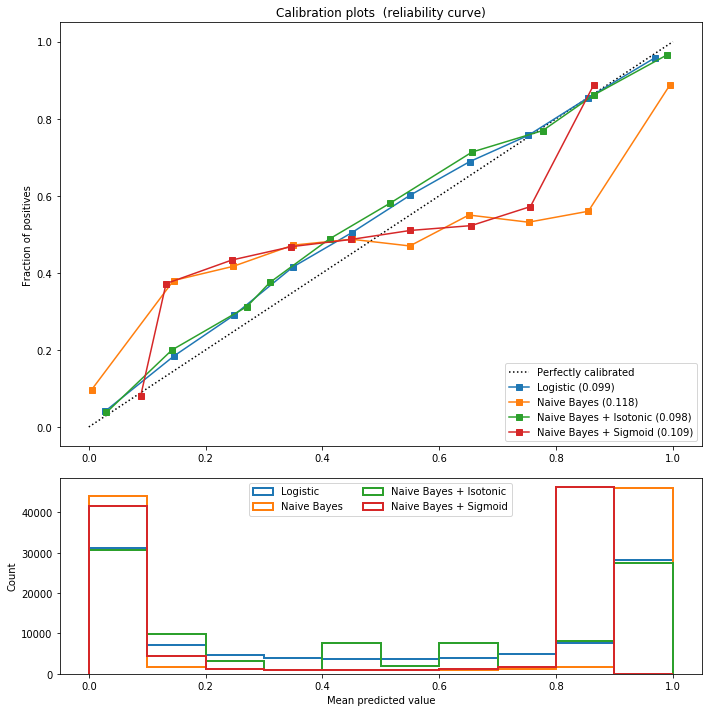

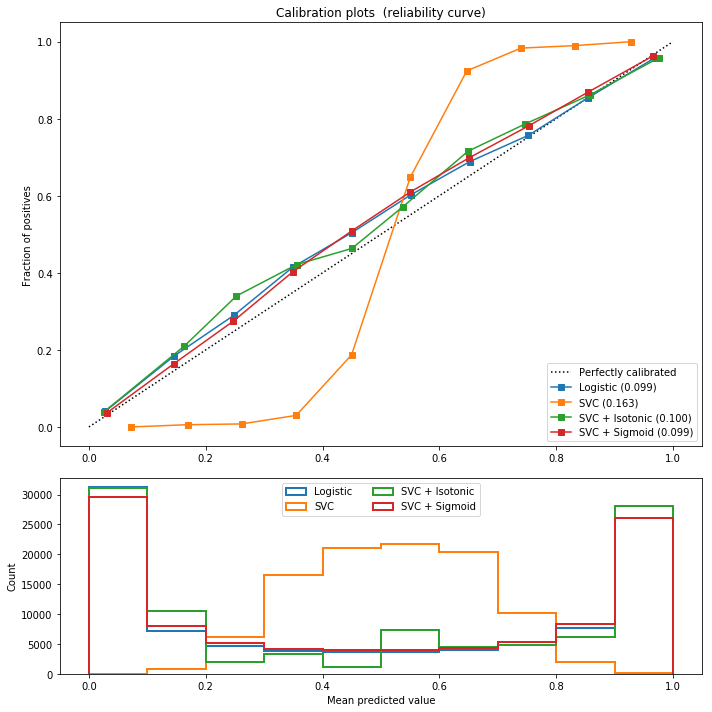

In [108]:
# Author: Alexandre Gramfort <alexandre.gramfort@telecom-paristech.fr>
#         Jan Hendrik Metzen <jhm@informatik.uni-bremen.de>
# License: BSD Style.

import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (brier_score_loss, precision_score, recall_score,
                             f1_score)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.model_selection import train_test_split


# Create dataset of classification task with many redundant and few
# informative features
X, y = datasets.make_classification(n_samples=100000, n_features=20,
                                    n_informative=2, n_redundant=10,
                                    random_state=random_state)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.99,
                                                    random_state=42)


def plot_calibration_curve(est, name, fig_index):
    """Plot calibration curve for est w/o and with calibration. """
    # Calibrated with isotonic calibration
    isotonic = CalibratedClassifierCV(est, cv=2, method='isotonic')

    # Calibrated with sigmoid calibration
    sigmoid = CalibratedClassifierCV(est, cv=2, method='sigmoid')

    # Logistic regression with no calibration as baseline
    lr = LogisticRegression(C=1., solver='lbfgs')

    fig = plt.figure(fig_index, figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    for clf, name in [(lr, 'Logistic'),
                      (est, name),
                      (isotonic, name + ' + Isotonic'),
                      (sigmoid, name + ' + Sigmoid')]:
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        if hasattr(clf, "predict_proba"):
            prob_pos = clf.predict_proba(X_test)[:, 1]
        else:  # use decision function
            prob_pos = clf.decision_function(X_test)
            prob_pos = \
                (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())

        clf_score = brier_score_loss(y_test, prob_pos, pos_label=y.max())
        print("%s:" % name)
        print("\tBrier: %1.3f" % (clf_score))
        print("\tPrecision: %1.3f" % precision_score(y_test, y_pred))
        print("\tRecall: %1.3f" % recall_score(y_test, y_pred))
        print("\tF1: %1.3f\n" % f1_score(y_test, y_pred))

        fraction_of_positives, mean_predicted_value = \
            calibration_curve(y_test, prob_pos, n_bins=10)

        ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
                 label="%s (%1.3f)" % (name, clf_score))

        ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
                 histtype="step", lw=2)

    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration plots  (reliability curve)')

    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="upper center", ncol=2)

    plt.tight_layout()

# Plot calibration curve for Gaussian Naive Bayes
plot_calibration_curve(GaussianNB(), "Naive Bayes", 1)

# Plot calibration curve for Linear SVC
plot_calibration_curve(LinearSVC(max_iter=10000), "SVC", 2)

plt.show()

#### Применим к нашей модели

Logistic:
	Brier: 0.109
	Precision: 0.853
	Recall: 0.957
	F1: 0.902

SVC:
	Brier: 0.225
	Precision: 0.889
	Recall: 0.925
	F1: 0.907

SVC + Isotonic:
	Brier: 0.099
	Precision: 0.897
	Recall: 0.917
	F1: 0.907

SVC + Sigmoid:
	Brier: 0.098
	Precision: 0.887
	Recall: 0.929
	F1: 0.908



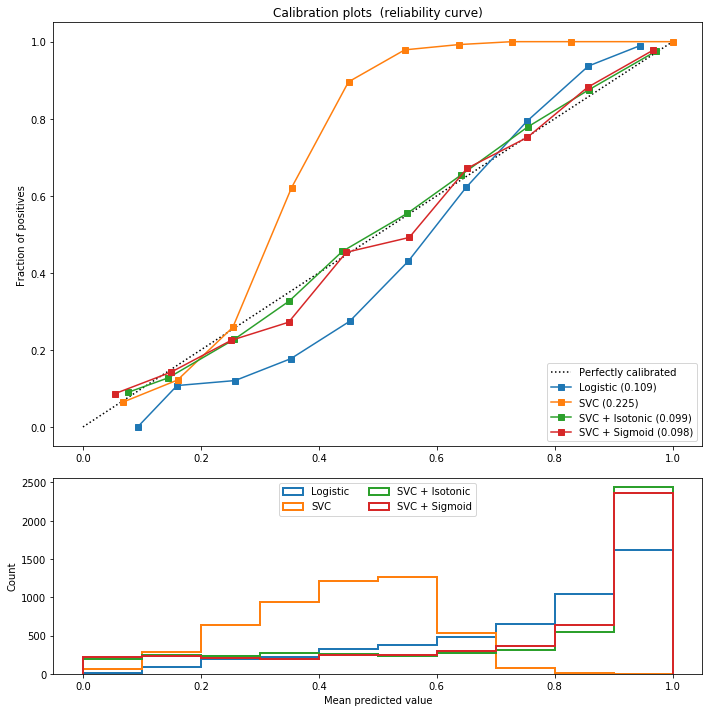

In [123]:
from sklearn.feature_extraction.text import TfidfVectorizer

y = le.transform(data['score'])
vectorizer = TfidfVectorizer()
doc_term_matrix = vectorizer.fit_transform(texts)

X_train, X_test, y_train, y_test = train_test_split(doc_term_matrix, y, test_size=0.5,
                                                    random_state=random_state)

plot_calibration_curve(LinearSVC(max_iter=10000), "SVC", 2)


## Пример 3: анализ поведения классификатора

#### Ядра в SVM и разделяюшие поверхности

<img src='kernels.png'>

#### Классификатор, ведущий себя "странно"

In [128]:
from sklearn import datasets
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [8]:
?train_test_split

In [129]:
digits = datasets.load_digits()
X_train, X_test, y_train, y_test = \
    train_test_split(digits.data, digits.target, test_size=0.33, random_state=random_state)

In [21]:
X_train[0]

array([ 0.,  0.,  0.,  1., 12.,  7.,  0.,  0.,  0.,  0.,  0.,  9., 16.,
       16.,  1.,  0.,  0.,  1.,  7., 15., 16., 14.,  0.,  0.,  0.,  4.,
       16., 16., 16., 16.,  0.,  0.,  0.,  0.,  0.,  3., 16., 16.,  0.,
        0.,  0.,  0.,  0.,  2., 16., 16.,  3.,  0.,  0.,  0.,  0.,  6.,
       16., 16.,  0.,  0.,  0.,  0.,  0.,  3., 15., 13.,  0.,  0.])

In [131]:
clf = svm.SVC(gamma=10e-7)

In [132]:
clf.fit(X_train, y_train)  

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1e-06, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [133]:
preds = clf.predict(X_test)

In [134]:
print(accuracy_score(y_test, preds))

0.18181818181818182


In [72]:
train_preds = clf.predict(X_train)
print(accuracy_score(y_train, train_preds))

0.20199501246882792


**Неожиданный ответ 1:** это **недо**обучение

**Неожиданный ответ 2:** это вина не радиального ядра, а гиперпараметров

С удачными гиперпараметрами:

In [135]:
clf = svm.SVC(gamma=0.001)
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
print(accuracy_score(y_test, preds))

0.98989898989899


С гиперпараметрами, приводящими к переобучению:

In [136]:
clf = svm.SVC(gamma=10)
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
print(accuracy_score(y_test, preds))
train_preds = clf.predict(X_train)
print(accuracy_score(y_train, train_preds))

0.10101010101010101
1.0


In [46]:
clf = svm.SVC()
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
print(accuracy_score(y_test, preds))
train_preds = clf.predict(X_train)
print(accuracy_score(y_train, train_preds))

/Users/xead/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.4006734006734007
1.0


**Далее: часть 2. Vowpal Wabbit**